## Rejection Based Inference

Formalized by [Tarave, 1997](https://www.genetics.org/content/genetics/145/2/505.full.pdf) and extended by [Beaumont, 2002](https://www.genetics.org/content/genetics/162/4/2025.full.pdf). Using code found in [this](https://github.com/florent-leclercq/Bayes_InfoTheory/blob/master/ABC_rejection.ipynb) repo. 

In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import norm, invgamma, gaussian_kde

%matplotlib inline
%config InlineBackend.figure_format='retina'

from cycler import cycler
plt.rcParams.update({'lines.linewidth': 2})
colors=[plt.cm.Set2(i) for i in np.linspace(0, 1, 8)]
plt.rcParams.update({'axes.prop_cycle': cycler('color', colors)})

### Generate Data


We will try to infer the unknown variance, $\sigma^2$ of a zero-mean Gaussian.

In [15]:
np.random.seed(1)
n_samples = 100

true_sigma = 2.
likelihood = norm(loc=0, scale = np.sqrt(true_sigma))

(dmin, dmax) = (-5, 5)
X = likelihood.rvs(size = n_samples)

# not sure what these are for yet...
lh_data = likelihood.pdf(X)
x_arr = np.arange(dmin, dmax, (dmax-dmin)/100.)
f_arr = likelihood.pdf(x_arr)

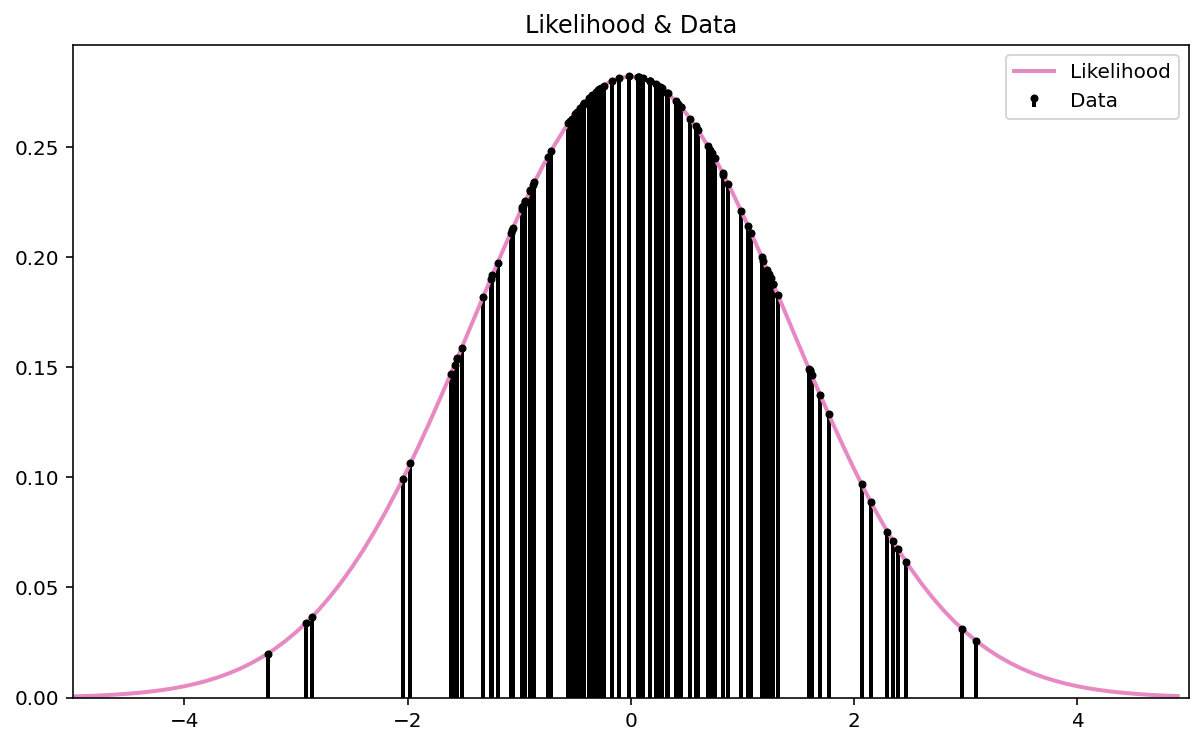

In [16]:
plt.figure(figsize=(10,6))
plt.xlim([dmin, dmax])

plt.plot(x_arr,
         f_arr,
         color=colors[3],
         label="Likelihood")
markerline, stemlines, baseline = plt.stem(X, lh_data, linefmt='-k', markerfmt='k.', label="Data")
baseline.set_visible(False)

plt.title("Likelihood & Data")
plt.legend()
plt.ylim(bottom=0.)
plt.show();

#### Analytic Solution

The inverse-Gamma is the conjugate prior for the variance of a Gaussian with fixed mean. We have a prior of:

$$ p(\sigma^2 \mid \alpha, \beta) = \text{Inv-Gamma}(\alpha, \beta) $$

Which gives us a posterior of: 

$$ p(\sigma^2 \mid X) = \text{Inv-Gamma}(\alpha', \beta') $$

$$ \alpha' = \alpha + \frac{n_{samples}}{2} $$

$$ \beta' = \beta + \frac{\sum (x_i - \mu)^2}{2} $$

More [here](https://people.eecs.berkeley.edu/~jordan/courses/260-spring10/other-readings/chapter9.pdf).

In [39]:
# if we want to do exact inference

alpha_prior = 5
beta_prior = 30

alpha_post = alpha_prior + n_samples / 2
beta_post = beta_prior + np.sum(X**2) / 2

sigma_post = invgamma(a = alpha_post, loc = 0, scale = beta_post)

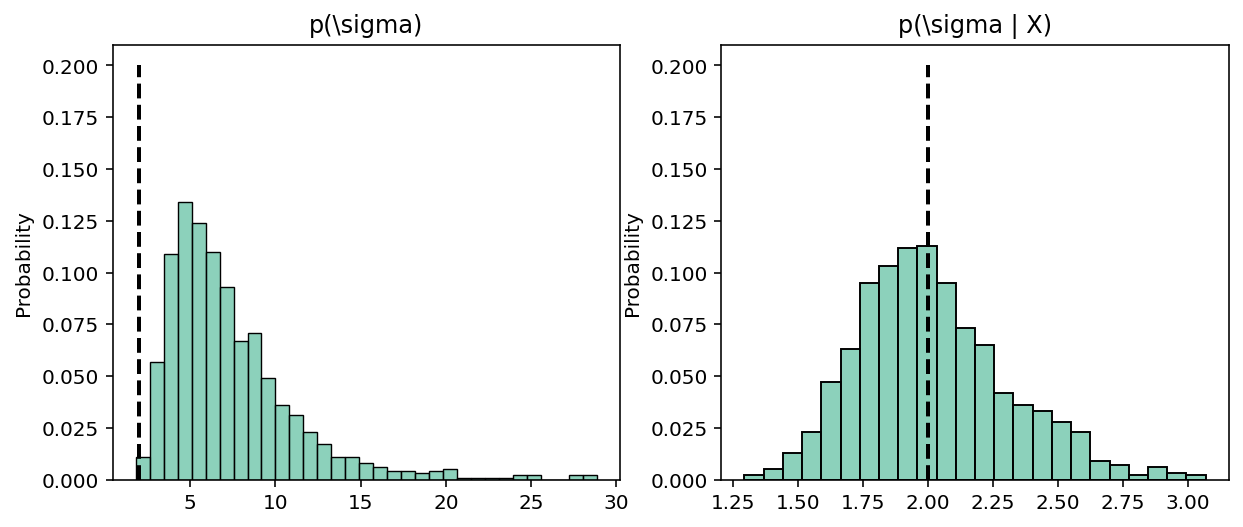

In [54]:
sigma_prior = invgamma(a = alpha_prior, loc = 0, scale = beta_prior)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

sns.histplot(sigma_prior.rvs(1000), stat = "probability", ax = ax[0]).set_title("p(\sigma)")
ax[0].plot([true_sigma,true_sigma],[0, 0.2], linestyle='--', color='black', label="true sigma")
sns.histplot(sigma_post.rvs(1000), stat = "probability", ax = ax[1]).set_title("p(\sigma | X)")
ax[1].plot([true_sigma,true_sigma],[0,.2], linestyle='--', color='black', label="true sigma");

#### Rejection Sampling

Given a parameter draw from the prior, the simulator simulates $n$ samples from a Gaussian with mean 0 and variance $\sigma^2$. The distance between the simulation and the real data is: 

$$ D(s, d) = \sqrt{(S(s) - S(k)) ^ 2} $$

Where $S$ is the summary statistic of $X$, our data. 

Notice that this method is very sensitive to weak or poorly specified priors. 

In [55]:
def simulator(var, num_samples = 250):
    return norm(loc=0., scale=np.sqrt(var)).rvs(size=num_samples)

def distance(sim_ss,data_ss):
    return np.sqrt(np.sum((sim_ss-data_ss)**2))

In [57]:
# the first summary statistic we try is the variance: 
def sufficient_summary(X):
    return np.var(X)

data_ss = sufficient_summary(X)
data_ss

1.5670030457693338

In [71]:
num_tries = 10000
for eps in [0.5]: #, 0.4, 0.3, 0.2, 0.1]:
    # we never call the `likelihood` function
    samples = []
    for _try in range(num_tries):
        # 1) simulate \sigma from prior
        prior_sim = sigma_prior.rvs(size = 1)
        # 2) forward generate data using the value of \sigma just samples
        data_sim = simulator(prior_sim)
        # 3) calculate the sufficient statistic of the simulated data
        sim_ss = sufficient_summary(data_sim)
        # 4) compare the estimated stat and the actual stat. 
        if (distance(sim_ss, data_ss) < eps):
            # accept
            samples.append(prior_sim)
    samples = np.array(samples).T
    fraction_accepted = len(samples) / num_tries
    
samples